#Библиотеки

In [ ]:
!pip install sentence_transformers
!pip install -q addict
!pip install -q segmentation-models-pytorch
!pip install torchvision
!pip install rdkit

In [ ]:
import matplotlib.pyplot as plt
from addict import Dict
import warnings
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import os
import string
import re
import json
import multiprocessing
from collections import Counter, defaultdict
from xml.dom import minidom
from detectron2.structures import BoxMode
import copy
from pqdm.processes import pqdm
from rdkit.Chem import Draw
from scipy.spatial.ckdtree import cKDTree

from utils import *
import numpy as np
from torchvision.io import read_image
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import cv2
import pandas as pd

import torch
from torchvision import datasets, transforms,models
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW, Adadelta
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensor
import segmentation_models_pytorch as smp
import wandb
import torch.nn.functional as F
from torch.utils.data import *
from tqdm import tqdm
from nltk.stem import PorterStemmer
import nltk
from nltk.stem import WordNetLemmatizer
#nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
#russian_stopwords = stopwords.words("russian")

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon.pyAvalonTools import GetAvalonCountFP

# TORCH

Dataset на примере работы с картинками

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Dataloader

In [ ]:
# на вход подаются датасеты
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Модель


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc2 = nn.Linear(2000,500)
        self.fc3 = nn.Linear(500,20)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x
net = Net()

Обучение

Loss-функция

In [ ]:
# регрессия
criterion = nn.MSELoss() # среднекваратичная ошибка
# бинарная классификация
criterion = nn.BCELoss() # нужно заранее прописывать функция активация - например сигмоиду
# многоклассовая классификация
criterion = nn.CrossEntropyLoss() # softmax включен, не надо его заранее прописывать
# На самом деле этого достаточно для решения большинства задач, так как более сложные задачи сводятся к более простым, то бишь регрессии и классификации

Оптимизаторы градиентного спуска

In [ ]:
# стандартный стохастический градиентный спуск
optimizer = SGD(net.parameters(),lr=0.01) # lr - скорость обучения
# более крутой Adam, Adadelta и AdamW
optimizer = Adam(net.parameters(), lr=0.01)
optimizer = AdamW(net.parameters(), lr=0.01)
optimizer = Adadelta(net.parameters(), lr=0.01)

Планировщик (Sheduler)

In [ ]:
# стандартный ReduceLROnPlateau создает динамический learning rate, уменьшает lr, когда метрика перестала улучшаться
scheduler = ReduceLROnPlateau(optimizer, 'min') # нужен оптимизатор, 'min' - мод регуляции lr

Пример обучения на fish semantic segmentation

In [ ]:
class Trainer:
    def __init__(self, model, criterion, optimizer, project, output_path, scheduler=None, config={}, device="cpu"):
        self.__model = model
        self.__criterion = criterion
        self.__optimizer = optimizer
        self.__scheduler = scheduler,
        self.__project = project
        self.__device = device
        self.__output_path = output_path
        self.__config = config

    def evaluate(self, loader):
        self.__model.to(self.__device)
        loader_length = len(loader)
        loss = 0
        with torch.no_grad():
            for batch in loader:
                torch.cuda.empty_cache()

                images = batch["image"].to(self.__device)
                masks = batch["mask"].cpu()

                outputs = model(images).cpu()
                batch_loss = self.__criterion(outputs, masks)
                loss += batch_loss.item()

        loss /= loader_length
        return loss

    def fit(self, loader, validation_loader=None, epochs=10):
        with wandb.init(project=self.__project, config=self.__config):
            wandb.watch(self.__model, self.__criterion, log="all")
            self.__model.to(self.__device)
            loader_length = len(loader)
            for epoch in range(epochs):
                loop = tqdm(loader)
                loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
                epoch_loss = 0
                for batch in loop:
                    torch.cuda.empty_cache()
                    self.__optimizer.zero_grad()

                    images = batch["image"].to(self.__device)
                    masks = batch["mask"].cpu()

                    outputs = self.__model(images).cpu()
                    batch_loss = self.__criterion(outputs, masks)

                    epoch_loss += batch_loss.item()
                    loop.set_postfix(loss=batch_loss.item())

                    batch_loss.backward()
                    self.__optimizer.step()



                epoch_loss /= loader_length
                loop.set_postfix(loss=epoch_loss)
                wandb.log({"loss": epoch_loss}, step=epoch+1)

                if validation_loader is not None:
                    validation_loss = self.evaluate(validation_loader)
                    loop.set_postfix(validation_loss=validation_loss)
                    wandb.log({"validation_loss": validation_loss}, step=epoch+1)

                    if self.__scheduler is not None:
                        scheduler.step(validation_loss)
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)
                else:
                    if self.__scheduler is not None:
                        scheduler.step()
                        lr = optimizer.state_dict()["param_groups"][0]["lr"]
                        wandb.log({"lr": lr}, step=epoch+1)

            torch.onnx.export(model, images, self.__output_path)
            wandb.save(self.__output_path)

Saving models.
Можно сохранять, как сами модели, так и их state_dict, который можно вставить в необученный объект класса модели, так и словарь, в котором хранится чекпоинт



In [ ]:
# Сохранение state_dict
torch.save(model.state_dict(), PATH)
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
# Сохранение самой модели
torch.save(model, PATH)
model = torch.load(PATH)
model.eval()
# Сохранение словаря
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(), # или 'model': model,
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# NLP

Embedding vectorizer

In [ ]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

input_texts = [
    "what is the capital of China?",
    "how to implement quick sort in python?",
    "Beijing",
    "sorting algorithms"
]

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-large")
model = AutoModel.from_pretrained("thenlper/gte-large")

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# (Optionally) normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:1] @ embeddings[1:].T) * 100
print(scores.tolist())

In [ ]:
sent_trans_model = SentenceTransformer("paraphrase-mpnet-base-v2")
news_data = [t.lower() for t in df["text"]]
bert_vectors = sent_trans_model.encode(news_data[:], show_progress_bar=True)
print(np.array(bert_vectors).shape)

TF-IDF

In [ ]:
ngram_range = (2,3)

min_df = 10
max_df = 1.
max_features = 1000

tfidf = TfidfVectorizer(encoding='utf-8',
                        analyzer = 'char',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        sublinear_tf=True,)

features_train = tfidf.fit_transform(X).toarray() # fit()-обучение transfrom()-применение
labels_train = y.reshape(-1,1)
print(features_train.shape)

features_test = tfidf.transform(test).toarray()
print(features_test.shape)
feature_names = tfidf.get_feature_names_out()
df_train = pd.DataFrame(features_train, columns=feature_names)
df_train.head()

Токенизация

In [ ]:
word_data = "It originated from the idea that \
there are readers who prefer learning new skills\
 from the comforts of their drawing rooms"
nltk_tokens = nltk.word_tokenize(word_data)
print(nltk_tokens)

Стемминг и Лемматизация
Обычно тексты содержат разные грамматические формы одного и того же слова, а также могут встречаться однокоренные слова. Лемматизация и стемминг преследуют цель привести все встречающиеся словоформы к одной, нормальной словарной форме.

Стемминг – это грубый эвристический процесс, который отрезает «лишнее» от корня слов, часто это приводит к потере словообразовательных суффиксов.

Лемматизация – это более тонкий процесс, который использует словарь и морфологический анализ, чтобы в итоге привести слово к его канонической форме – лемме.

Отличие в том, что стеммер (конкретная реализация алгоритма стемминга – прим.переводчика) действует без знания контекста и, соответственно, не понимает разницу между словами, которые имеют разный смысл в зависимости от части речи. Однако у стеммеров есть и свои преимущества: их проще внедрить и они работают быстрее. Плюс, более низкая «аккуратность» может не иметь значения в некоторых случаях.

In [ ]:


e_words= ["wait", "waiting", "waited", "waits"]

ps = PorterStemmer()

for w in e_words:
    rootWord = ps.stem(w)
    print(rootWord)


wordnet_lemmatizer = WordNetLemmatizer()
text = "studies studying cries cry"
tokenization = nltk.word_tokenize(text)

for w in tokenization:
    print("Lemma for {} is {}".format(w, wordnet_lemmatizer.lemmatize(w)))

# Images

Предобработка

In [ ]:
img = cv2.imread('1630066830.2647.jpg')
# изначально BGR, а не RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Визуализируем
plt.imshow(img)
plt.show()

In [ ]:
# набор трансформаций, которые применяются к изображениям
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
img_trans = data_transform()
#Перечень основных трансформаций transforms
# Ресайз
transforms.Resize(size=(height,width))
# Центральное обрезание
transforms.CenterCrop(size=(height,width))
# случайные горизонтальные и вертикальные перевороты
transforms.RandomHorizontalFlip(p)
transforms.RandomVerticalFlip(p) # p - вероятность переворота
# Делает со всех сторон отступы на заданное значение
transforms.Pad(padding=pad) # pad - значение отступа
# Нормализация по каждому объему(изначально 3)
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# Конвертации
transforms.ToImage() # из чего угодно в Image
transforms.ToDtype() # конвертирует в нужный тип
transforms.ToPILImage() # в PIL image
transforms.ToTensor() # В тензор


# Семантическая сегментация

Ручной U-net

In [ ]:
class Unet(nn.Module):
    def __init__(self,n_channels = 3,size=(572,572)):
        super(Unet,self).__init__()
        self.conv1 = nn.Conv2d(n_channels,64,kernel_size = 3)
        self.conv2 = nn.Conv2d(64,64,kernel_size = 3)
        self.maxPool = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(64,128,kernel_size = 3)
        self.conv4 = nn.Conv2d(128,128,kernel_size = 3)
        self.maxPool = nn.MaxPool2d(2, stride=2)
        self.conv5 = nn.Conv2d(128,256,kernel_size = 3)
        self.conv6 = nn.Conv2d(256,256,kernel_size = 3)
        self.maxPool = nn.MaxPool2d(2, stride=2)
        self.conv7 = nn.Conv2d(256,512,kernel_size = 3)
        self.conv8 = nn.Conv2d(512,512,kernel_size = 3)
        self.maxPool = nn.MaxPool2d(2, stride=2)
        self.conv9 = nn.Conv2d(512,1024,kernel_size = 3)
        self.conv10 = nn.Conv2d(1024,1024,kernel_size = 3)
        self.conv_9 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv_8 = nn.Conv2d(1024, 512, 3)
        self.conv_7 = nn.Conv2d(512, 512, 3)
        self.conv_6 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv_5 = nn.Conv2d(512, 256, 3)
        self.conv_4 = nn.Conv2d(256, 256, 3)
        self.conv_3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv_2 = nn.Conv2d(256, 128, 3)
        self.conv_1 = nn.Conv2d(128, 128, 3)
        self.conv_0 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_01 = nn.Conv2d(128, 64, 3)
        self.conv_02 = nn.Conv2d(64, 64, 3)
        self.last = nn.Conv2d(64,64,1)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x1 = transforms.CenterCrop((392,392))
        x1 = x1(x)
        x = self.maxPool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x2 = transforms.CenterCrop((200,200))
        x2 = x2(x)
        x = self.maxPool(x)
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x3 = transforms.CenterCrop((104,104))
        x3 = x3(x)
        x = self.maxPool(x)
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x4 = transforms.CenterCrop((56,56))
        x4 = x4(x)
        x = self.maxPool(x)
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.conv_9(x)
        #print(x4.size(),x.size())
        x = torch.cat((x4,x),1)
        #print(x.size())
        x = self.relu(self.conv_8(x))
        x = self.relu(self.conv_7(x))
        x = self.conv_6(x)
        x = torch.cat((x3,x),1)
        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_4(x))
        x = self.conv_3(x)
        x = torch.cat((x2,x),1)
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_1(x))
        x = self.conv_0(x)
        x = torch.cat((x1,x),1)
        x = self.relu(self.conv_01(x))
        x = self.relu(self.conv_02(x))
        x = self.last(x)
        return x

Готовая модель на примере семантической сегментации рыб

In [ ]:
config = Dict({
    "images_path": "../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset",
})

train_config = Dict({
    "project": "Fish Semantic Segmentation",
    "output_path": "model.onnx",
    "batch_size": 16,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 10,

    "model": {
        "type": "UNet",
        "parameters": {
            "encoder_name": "resnet34",
            "in_channels": 3,
        }
    },

    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.01,
        }
    },
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
        }
    },

    "input_size": (256, 256),
    "augmentations": A.Compose([
                                A.Downscale(scale_min=0.5, scale_max=0.75, p=0.2),
                                A.HorizontalFlip(p=0.5),
                                A.Blur(p=0.2),
                                A.VerticalFlip(p=0.5),
                                A.RandomFog(p=0.2),
                                A.RandomBrightness(p=0.2),
                                A.RandomBrightnessContrast(p=1),
                                A.RandomGamma(p=0.7),
                                ToTensor(), # augmentation также можно использовать для преобразования изображений
    ]),
    "num_workers": 4,
})

In [ ]:
class FishDataset(Dataset):
    def __init__(self, path, augmentations=None, size=(512, 512)):
        self.__images_masks = []
        self.__size = size
        self.__augmentations = augmentations
        if os.path.exists(path):
            self.__path = path
            for class_ in os.listdir(self.__path):
                class_path = os.path.join(self.__path, class_)
                if os.path.isdir(class_path):
                    images_path = os.path.join(class_path, class_)
                    images = os.listdir(images_path)

                    masks_path = os.path.join(class_path, f"{class_} GT")
                    masks = os.listdir(masks_path)

                    for image in images:
                        if image in masks:
                            mask = masks[masks.index(image)]

                            image_path = os.path.join(images_path, image)
                            mask_path = os.path.join(masks_path, mask)

                            self.__images_masks.append((image_path, mask_path))
                        else:
                            logging.warning(f"For image '{image}', mask wasn't found. It is going to be skipped")
        else:
            logging.error(f"Path '{path}' doesn't exists")


    def __len__(self):
        return len(self.__images_masks)

    def load_image(self, path, channels="RGB"):
        width, height = self.__size
        loader = A.Compose([
            A.Resize(width=width, height=height),
        ])

        image = np.array(Image.open(path).convert(channels))
        return loader(image=image)["image"]

    def __getitem__(self, index):
        if index <= len(self.__images_masks):
            image_path, mask_path = self.__images_masks[index]
            image = self.load_image(image_path)
            mask = self.load_image(mask_path, channels="L")
            if self.__augmentations is not None:
                augmentated = self.__augmentations(image=image, mask=mask)
                return Dict(augmentated)

            return Dict({
                "image": image,
                "mask": mask,
            })

In [ ]:
dataset = FishDataset(path=config.images_path,
                      augmentations=train_config.augmentations,
                      size=train_config.input_size)

# Трансформеры и блоки внимания


Attention - некоторая функция, которая помогает учитывать контекст. Изначально данный механизм был придуман для задачи перевода языка. Работал он по следующему принципу: для каждого слова из исходного предложения и текущего состояния декодера применялся attention, после чего выдавал "важность" слов для перевода у текущего состояния декодера. Далее эти важности перемножались с соответствующими векторами исходных слов и получался некоторый вектор, передающий в декодер наиболее вероятное слово. На деле attention функция может быть любоей. Более подробно https://qudata.com/ml/ru/NN_Attention.html

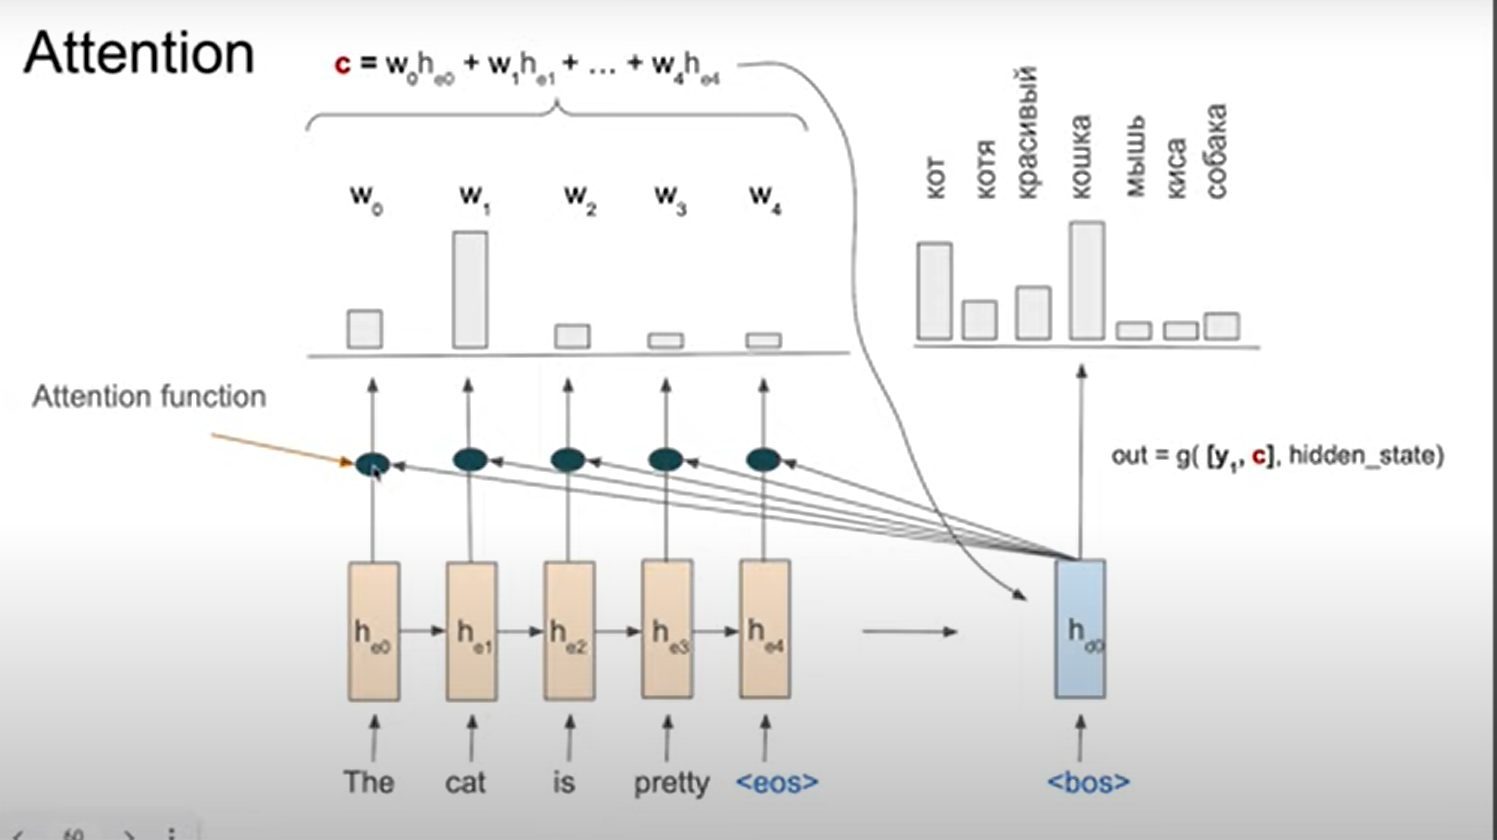

Self-attention - применения Attention не между декодером и енкодером, а между частями себя. например в енкодере есть несколько ембеддингов слов. Мы пропускаем Attention для него и для всех остальных слов, потом каким-либо образом добавляем полученную информацию с исходный вектор. Аналогично для всех остальных слов(при этом сверяется со старыми предыдущими слова, не измененными после self-attention) Данный процесс можно распараллелить. В декодере можно аналогично, но учитывая только уже переведенные слова. Более подробное использование https://youtu.be/f544TipD2QY?si=QGfdFVeNZ5d3Lz8s. Механизм использует 3 параметра K,V,Q(key,value,query), над которыми происходят некоторые процедуры.

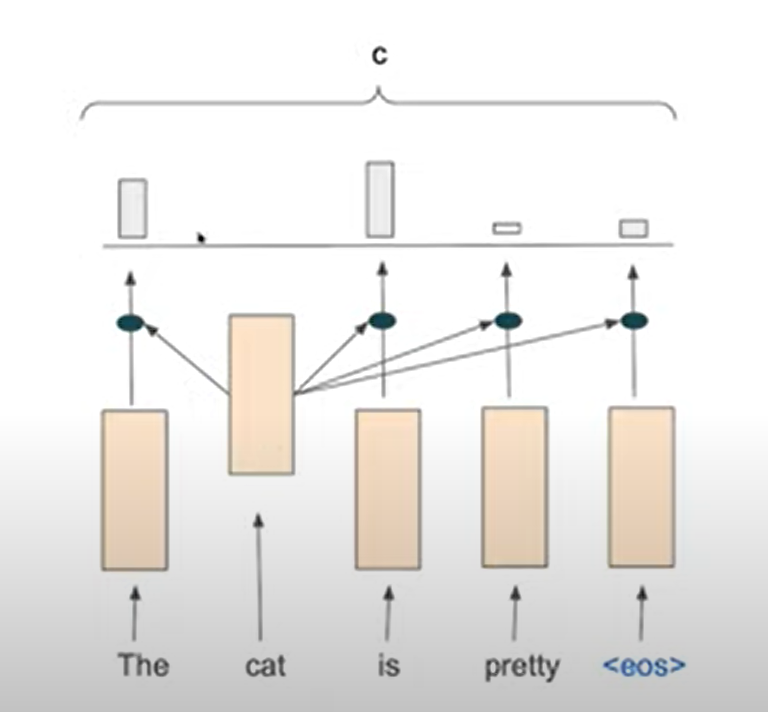

Multi-Head Attention - использование нескольких self и обычных Attention

In [ ]:
#Внутри себя по сути содержит много self-attention
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, **kwargs):
        super().__init__(**kwargs)

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim//n_heads
        self.device = device

        self.dropout = nn.Dropout(dropout)

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        E = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            E = E.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(E, dim=-1)

        X = torch.matmul(self.dropout(attention), V)

        X = X.permute(0, 2, 1, 3).contiguous()

        X = X. view(batch_size, -1, self.hid_dim)

        X = self.fc_o(X)

        return X, attention

Transformer - довольно большая модель, соединяющая в себе много attention-слоев. Более подробно https://colab.research.google.com/github/akash-agni/LearningLanguage/blob/main/Attention%20Is%20All%20You%20Need.ipynb

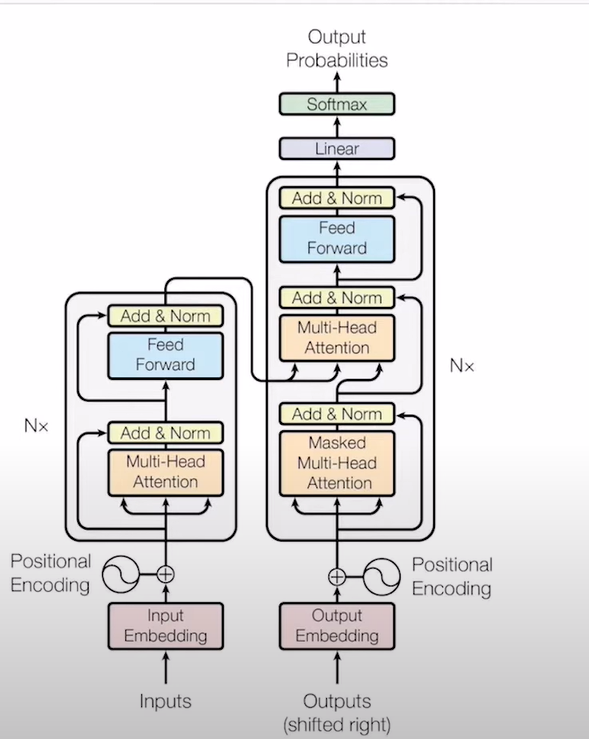

Трансформеры часто используются в работе с текстом, в том числе в задаче перевода изображения в текст. Из изображения сверточными моделями input превращается в некоторый вектор признаков текста, который превращается в ембеддинг текста, надо которым уже производится трансформер. Пример реализации: https://www.kaggle.com/code/dlobatog/sd-image-to-text

# Object detection
Есть множество способов решения данной задачи - определения множества объектов на изображении(классификация+определение границ). CNN, Fast_RNN, FPN, YOLO и другие. Все они используют различные идеи.
В первую очередь возьмем функцию потерь IoU, которая определяет отношение пересечения правильного Bounding box и получившегося, а также их объединение.


One stage object detection - каким-либо способом(например CNN) выгружаем модель признаков в 13X13X((n+5)Xk), где 13X13 зависит от CNN, n - число классов, k - число детекторов на одну такую карту(Эти k фигур называются якорями или якорными ящиками. Якоря — это не что иное, как список ширины и высоты возможных форм фигур,Важно понимать, что эти якоря выбираются заранее. Они постоянны и не меняются во время тренировок. Но их YOLO и SSD вычисляют своими методами), 5 - 4 числа ограничивающего прямоугольника и 1 число уверенности. Тогда всего предсказаний объектов 13X13Xk.Но зачастую объектов на изображении меньше. Большинство полученных объектов пересекаются, поэтому воспользуемся методом немаксимального подавления(NMS).
Короче говоря, NMS сохраняет прогнозы с наивысшими показателями достоверности и удаляет любые другие поля, которые перекрывают их более чем на определенный порог (скажем, 60%).

In [ ]:
# Готовые one-stage модели https://github.com/implus/GFocalV2/tree/master/configs/groie
# Пример реализации https://vince-cv.github.io/2020/11/02/Custom-Single-Stage-Object-Detector/

In [ ]:
# пример предикта, модели а также рисования bbox-ов
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch
from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names
import torchvision
np.random.seed(42)
def get_model(device):
    # Load the model.
    model = torchvision.models.detection.fcos_resnet50_fpn(pretrained=True)
    # Load the model onto the computation device.
    model = model.eval().to(device)
    return model
# Create different colors for each class.
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))
# Define the torchvision image transforms.
transform = transforms.Compose([
    transforms.ToTensor(),
])
def predict(image, model, device, detection_threshold):
    """
    Predict the output of an image after forward pass through
    the model and return the bounding boxes, class names, and
    class labels.
    """
    # Transform the image to tensor.
    image = transform(image).to(device)
    # Add a batch dimension.
    image = image.unsqueeze(0)
    # Get the predictions on the image.
    with torch.no_grad():
        outputs = model(image)
    # Get score for all the predicted objects.
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # Get all the predicted bounding boxes.
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # Get boxes above the threshold score.
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    labels = outputs[0]['labels'][:len(boxes)]
    # Get all the predicited class names.
    pred_classes = [coco_names[i] for i in labels.cpu().numpy()]
    return boxes, pred_classes, labels
def draw_boxes(boxes, classes, labels, image):
    """
    Draws the bounding box around a detected object.
    """
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color[::-1], 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color[::-1], 2,
                    lineType=cv2.LINE_AA)
    return image

Feature Pyramid Networks - свёрточная нейронная сеть, построенная в виде пирамиды, служащая для объединения достоинств карт признаков нижних и верхних уровней сети, первые имеют высокое разрешение, но низкую семантическую, обобщающую способность; вторые — наоборот

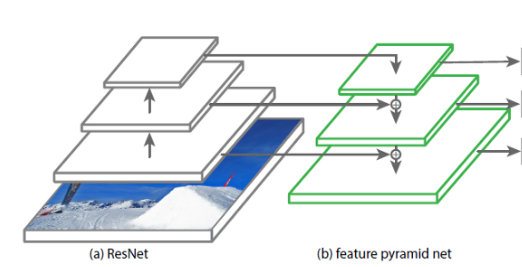

Two stage detection -
1.Определение набора гипотез.
2.Извлечение из предполагаемых регионов признаков с помощью сверточной нейронной сети и их кодирование в вектор.
3.Классификация объекта внутри гипотезы на основе вектора из шага 2.
4.Улучшение (корректировка) координат гипотезы.
5.Все повторяется, начиная с шага 2, пока не будут обработаны все гипотезы с шага 1.
Имея определенное изображение на входе первым делом, оно разбивается на маленькие гипотезы разных размеров. Например используют Selective Search – верхнеуровнево, он позволяет составить набор гипотез (класс объекта пока не имеет значения), на основе сегментации определить границы объектов по интенсивности пикселей, перепаду цветов, контраста и текстур.
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Отдельной проблемой задачи может быть обучение, а имеено использование кастомного датасета при обучения. Чаще всего используется структура COCO(подробнее про формирование тут:
 https://pythonhint.com/post/1146392728288358/create-ms-coco-style-dataset#:~:text=In%20Python%2C%20creating%20an%20MS,the%20images%20and%20the%20labels) при формировании датасетов. Для каждой картинки есть все данные по ней: название, id, bboxes,classes и другая полезные фичи.
https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/

In [ ]:
# Полная модель
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))

            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)

            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height

            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image_resized, target
    def __len__(self):
        return len(self.all_images)

Также для данной задачи подходят и трансформеры, описанные в предыдущем блоке.
https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-huggingface-detr-on-custom-dataset.ipynb
https://github.com/jozhang97/DETA - лучшая модель по точности(из видео)

# Генеративные модели
методы искусственного интеллекта, которые используются для создания новых данных (изображений, музыки, текста и прочих) на основе обучающего датасета, состоящего из большого количества данных.

Автокодировщики - модели, состоящие из енкодера и декодера. На вход подаются данные, проводится некоторое преображение их(например свертка) - енкодер, превращающий входной тензор в "латентное" пространство, которое уже декодировщик возвращает в исходное состояние. Полученные данные сравниваются с подавшимися на вход.

In [ ]:
# пример автокодировщика
class AE(nn.Module):
  def __init__(self,inp_dim,hidden_dim):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(inp_dim,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,hidden_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(hidden_dim,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,inp_dim)
    )
  def forward(self,x):
    shapes = x.shape
    x = x.view(x.size(0),-1)
    return self.decoder(self.encoder(x)).view(*shapes)
  
  def encode(self,x):
    x = x.view(x.size(0),-1)
    return self.encoder(x)

Можно также добавить дополнительный шум в данные и проводить автокодировщик с зашумленнными данными, при этом ответ сравнивать с входными данными.

Самый очевидный способ применения автокодировщика - снижение размерности. Поскольку вместо огромных входных данных пожно их преобразовать в некоторый вектор, имеющие полезные данные, основанные на основных, после чего работать с уже полученными данными.

Также автокодировщики можно использовать для обнаружения аномалий данных. То есть обучим AE на каких-либо данных, если теперь на вход подать например класс, которого не было при исходном обучении, получится слишком отличающиеся наборы данных. Таким образом можно оценить аномалию и не подать на вход, например, того же классификатора.

Variational Auto-Encoder - обычный енкодер, потом из него мы возвращаем некоторое распределение, которое прогоняется через семплер(берет некоторую выборку), подается в латентное пространство. Дальше все стандартно

GAN - генеративно состязательные сети. Идея - откинем часть с енкодером. Оставим только латентное пространство и декодер. А также будем классифицировать "хорошесть" данных. на примере картинок: картинка из датасета или близкая к ней должна быть хорошей, а картинка не похожая на картинку из датасета - плохая. При этом декодер "хочет", чтобы хорошесть полученной картинки была высокой. При этом классификатор(его здесь также называют дискриминатором) пытается занизить хорошесть модели, а генератор - наоборот увеличить. За счет чего и возникает состязательность.
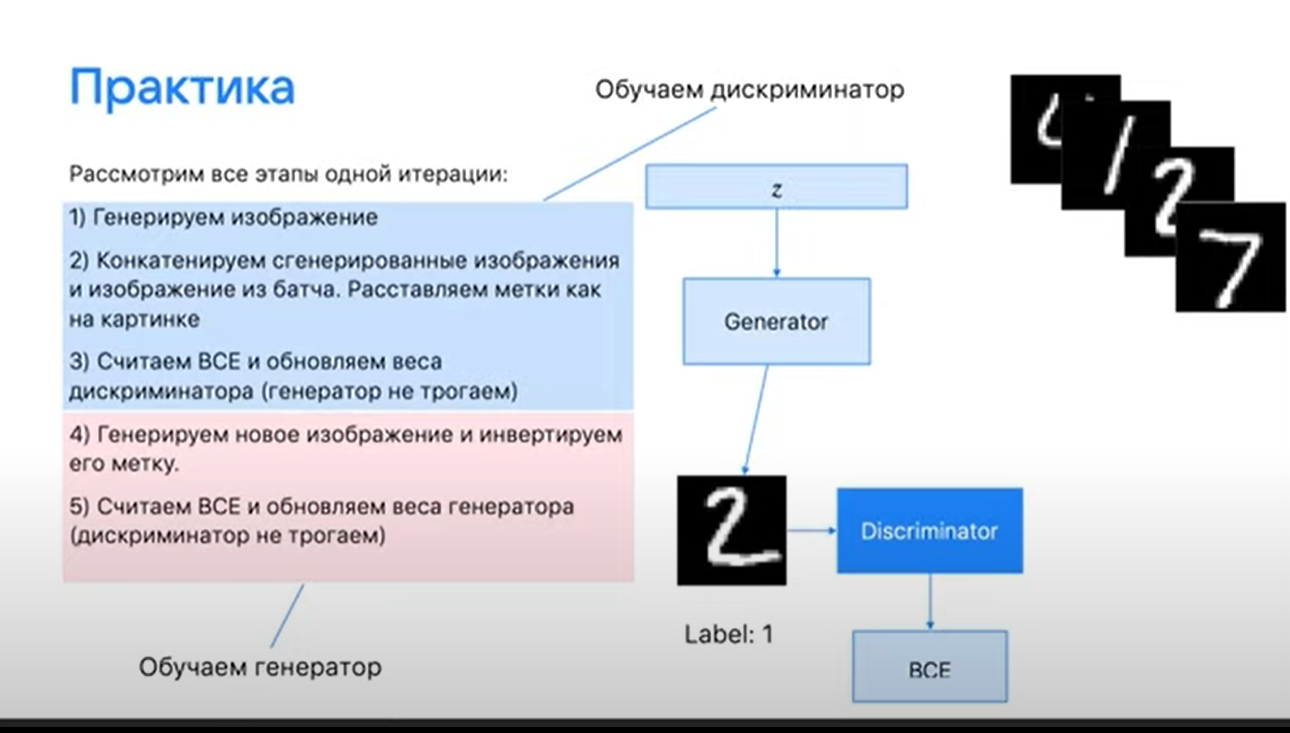

Теперь можно по полученному шуму, заброшенному в генератор, получить некоторое изображение.
Сейчас - StyleGAN одна из лучших моделей(на 2022 год)

# Химия

Базовая работы

In [ ]:
# преобразование строки SMILES в молекулу
mols_rdkit = Chem.MolFromSmiles('CCOc1ccccc1O')
mols_rdkit # нарисует молекулу

In [ ]:
# Различные функции
# рисует сразу несколько молекул
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(train['smiles'][:20].values))
# добавляет водород
Chem.AddHs(mol)
# возвращает число атомов
mol.GetNumAtoms()
# возвращает число тяжелых атомов
mol.GetNumHeavyAtoms()
# больше информации
https://rdkit.org/docs/

Фингерпринты -
Некоторый набор признаков, который можно вытянуть из представления молекулы, по которому уже можно создавать модели для нашей задачи.
Пример использования нескольких фингепринтов сразу:

In [ ]:
def all_fingerprints(mol):
  desc = AllChem.GetMACCSKeysFingerprint(mol)
  arr1 = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr1)
  desc = GetAvalonCountFP(mol,nBits = 1024)
  arr2 = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr2)
  desc = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
  arr3 = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr3)
  desc = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512)
  arr4 = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr4)
  desc = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)
  arr5 = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr5)
  desc = AllChem.GetHashedMorganFingerprint(mol,2,nBits=4096)
  arr6 = np.zeros((1,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(desc, arr6)
  return np.concatenate((arr1,arr2,arr3,arr4,arr5,arr6)).reshape(1,-1).flatten()
def make_MACCSKeysFingerPrint(mol):
  desc = AllChem.GetMACCSKeysFingerprint(mol)
  arr = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr)
  return arr
def make_avalon(mol):
  desc = GetAvalonCountFP(mol,nBits = 1024)
  arr = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr)
  return arr
def make_top(mol):
  desc = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)
  arr = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr)
  return arr
  return arr
def make_RDFK(mol):
  desc = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512)
  arr = np.zeros((1,),dtype=int)
  DataStructs.ConvertToNumpyArray(desc,arr)
  return arr
def make_atomPair(mol):
    desc = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)
    arr = np.zeros((1,),dtype=int)
    DataStructs.ConvertToNumpyArray(desc,arr)
    return arr
def HashedMorganFingerprint(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol,2,nBits=4096)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

GAN для молекул - https://www.kaggle.com/code/shivanshuman/gans-for-molecules
статья про использование GAN для генерации молекул:  https://link.springer.com/chapter/10.1007/978-3-030-91390-8_11

Molecule getting bboxes


In [ ]:
def _get_svg_doc(mol):
    """
    Draws molecule a generates SVG string.
    :param mol:
    :return:
    """
    dm = Draw.PrepareMolForDrawing(mol)
    d2d = Draw.MolDraw2DSVG(300, 300)
    d2d.DrawMolecule(dm)
    d2d.AddMoleculeMetadata(dm)
    d2d.FinishDrawing()
    svg = d2d.GetDrawingText()

    doc = minidom.parseString(svg)
    return doc
def get_bbox(smiles, unique_labels, atom_margin=12, bond_margin=10):
    """
    Get list of dics with atom-smiles and bounding box [x, y, width, height].
    :param smiles: STR
    :param unique_labels: dic with labels and idx for training.
    :param atom_margin: margin for bbox of atoms.
    :param bond_margin: margin for bbox of bonds.

    :return:
    """
    # replace unique labels to decide with kind of labels to look for
    labels = defaultdict(int)
    for k, v in unique_labels.items():
        labels[k] = v

    mol = Chem.MolFromSmiles(smiles)

    doc = _get_svg_doc(mol)

    # Get X and Y from drawing and type is generated
    # from mol Object, concatenating symbol + formal charge
    atoms_data = [{'x':    int(round(float(path.getAttribute('drawing-x')), 0)),
                   'y':    int(round(float(path.getAttribute('drawing-y')), 0)),
                   'type': ''.join([a.GetSymbol(), str(a.GetFormalCharge())])} for path, a in
                  zip(doc.getElementsByTagName('rdkit:atom'), mol.GetAtoms())]

    annotations = []
    # anotating bonds
    for path in doc.getElementsByTagName('rdkit:bond'):

        # Set all '\' or '/' as single bonds
        ins_type = path.getAttribute('bond-smiles')
        if (ins_type == '\\') or (ins_type == '/'):
            ins_type = '-'

        # make bigger margin for bigger bonds (double and triple)
        _margin = bond_margin
        if (ins_type == '=') or (ins_type == '#'):
            _margin *= 1.5

        # creating bbox coordinates as XYWH.
        begin_atom_idx = int(path.getAttribute('begin-atom-idx')) - 1
        end_atom_idx = int(path.getAttribute('end-atom-idx')) - 1
        x = min(atoms_data[begin_atom_idx]['x'], atoms_data[end_atom_idx]['x']) - _margin // 2  # left-most pos
        y = min(atoms_data[begin_atom_idx]['y'], atoms_data[end_atom_idx]['y']) - _margin // 2  # up-most pos
        width = abs(atoms_data[begin_atom_idx]['x'] - atoms_data[end_atom_idx]['x']) + _margin
        height = abs(atoms_data[begin_atom_idx]['y'] - atoms_data[end_atom_idx]['y']) + _margin

        annotation = {'bbox':        [x, y, width, height],
                      'bbox_mode':   BoxMode.XYWH_ABS,
                      'category_id': labels[ins_type]}
        annotations.append(annotation)

    # annotating atoms
    for atom in atoms_data:
        _margin = atom_margin

        # better to predict close carbons (2 close instances affected by NMS)
        if atom['type'] == 'C0':
            _margin /= 2

        # Because of the hydrogens normally the + sign falls out of the box
        if atom['type'] == 'N1':
            _margin *= 2

        annotation = {'bbox':        [atom['x'] - _margin,
                                      atom['y'] - _margin,
                                      _margin * 2,
                                      _margin * 2],
                      'bbox_mode':   BoxMode.XYWH_ABS,
                      'category_id': labels[atom['type']]}
        annotations.append(annotation)

    return annotations

Molecule embedding - https://github.com/ersilia-os/eos2lm8/tree/main

Использование gnn для предсказания свойств молекулы - https://github.com/masashitsubaki/molecularGNN_smiles

Getting molecule from graph

In [ ]:
def mol_from_graph(atoms, bonds):
    """ construct RDKIT mol object from atoms, bonds and bond types
    atoms: list of atom symbols+fc. ex: ['C0, 'C0', 'O-1', 'N1']
    bonds: list of lists of the born [atom_idx1, atom_idx2, bond_type, score]
    """

    # create and empty molecular graph to add atoms and bonds
    mol = Chem.RWMol()
    nodes_idx = {}
    bond_types = {'SINGLE':   Chem.rdchem.BondType.SINGLE,
                  'DOUBLE':   Chem.rdchem.BondType.DOUBLE,
                  'TRIPLE':   Chem.rdchem.BondType.TRIPLE,
                  'AROMATIC': Chem.rdchem.BondType.AROMATIC}

    # add nodes
    for idx, node in enumerate(atoms):
        # neutral formal charge
        if ('0' in node) or ('1' in node):
            a = node[:-1]
            fc = int(node[-1])
        if '-1' in node:
            a = node[:-2]
            fc = -1
        # create atom object
        a = Chem.Atom(a)
        a.SetFormalCharge(fc)

        # add atom to molecular graph (return the idx in object)
        atom_idx = mol.AddAtom(a)
        nodes_idx[idx] = atom_idx

    # add bonds
    existing_bonds = set()
    for idx_1, idx_2, bond_type, score in bonds:
        if (idx_1 in nodes_idx) and (idx_2 in nodes_idx):
            if (idx_1, idx_2) not in existing_bonds and (idx_2, idx_1) not in existing_bonds:
                try:
                    mol.AddBond(nodes_idx[idx_1], nodes_idx[idx_2], bond_types[bond_type])
                except:
                    continue
        existing_bonds.add((idx_1, idx_2))
        if Chem.MolFromSmiles(Chem.MolToSmiles(mol.GetMol())):
            # save safe structure
            prev_mol = copy.deepcopy(mol)
        # check if last addition broke the molecule
        else:
            # load last structure
            mol = copy.deepcopy(prev_mol)

    mol = mol.GetMol()
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    return Chem.MolToSmiles(mol)